In [6]:
#!pip freeze
#!pip install tensorflow-gpu==1.12

In [1]:
#!python setup.py install --user
# Copyright (C) PROWLER.io 2018
#
# Licensed under the Apache License, Version 2.0

# Script to reproduce Figure 3 from Sun et al.
import numpy as np
import pandas as pd
#import seaborn as sns
from sklearn.model_selection import train_test_split
import gpflow as gf

from demo.data import load_data, plot_model_performance, median_distance_local, DEFAULT_RANDOM_SEED
from kernel_learning.hybrid_kernel import HybridKernel
from kernel_learning.primitive_kernels import load_default_basis_kernels
from kernel_learning.utils import PrintAction, run_adam

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
plt.style.use('ggplot')

In [2]:
DATA_TYPE = 'airline'  # mauna, random, airline, sinusoid
NORMALISE_DATA = True
PREDICT_EXTRAPOLATION = True
N_NETWORK_LAYERS = 3  # Default 3
LEARNING_RATE = 1e-2  # Default 1e-3
ITERATIONS = 2000000  # Default 2000000, runs in 20 seconds
N_DATA_SAMPLES = 128
EXTRAPOLATION_FRACTION = 1.0  # How far to extrapolate relative to original data

x_raw, y_raw = load_data(DATA_TYPE, normalise_data=False, seed=DEFAULT_RANDOM_SEED, n_samples=N_DATA_SAMPLES)
n_extended_samples = int(len(x_raw) * (1 + EXTRAPOLATION_FRACTION))
x_raw_extended, y_raw_extended = load_data(DATA_TYPE, normalise_data=False, seed=DEFAULT_RANDOM_SEED, n_samples=n_extended_samples)
x_data, y_data = load_data(DATA_TYPE, normalise_data=True, seed=DEFAULT_RANDOM_SEED, n_samples=N_DATA_SAMPLES)

data_lengthscale = median_distance_local(x_data).astype('float32')
dx = x_data[1] - x_data[0]

if PREDICT_EXTRAPOLATION:
    n_extend = int(len(x_data) * EXTRAPOLATION_FRACTION)
    x_extended = x_data[0:n_extend] - np.min(x_data) + np.max(x_data)
    x_predict = np.concatenate([x_data, x_extended])
else:
    x_predict = x_data

# Define kernel network
input_dims = x_data.shape[1]
gf.reset_default_graph_and_session()
kernel_list = load_default_basis_kernels(data_lengthscale, input_dims)
hybrid_kernel = HybridKernel(input_dim=1, basis_kernels=kernel_list, n_layers=N_NETWORK_LAYERS)
hybrid_kernel.dump_weights()

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Kernel weights:  [[0.05465876 0.09066964 0.07699962 0.06866616 0.04100117 0.04099966
  0.03488023 0.08538601]
 [0.06881969 0.07550454 0.03253653 0.09186937 0.08327767 0.04452119
  0.04261406 0.04271278]
 [0.05026514 0.06404728 0.05824656 0.04945182 0.06949081 0.03996837
  0.04950904 0.05414762]
 [0.05975437 0.0803235  0.04372961 0.06338965 0.06827591 0.03415315
  0.06922155 0.04190776]
 [0.03531572 0.09055535 0.091602   0.08177483 0.05028836 0.03735451
  0.07401456 0.05875953]
 [0.03887739 0.06219856 0.03339928 0.08808253 0.04742375 0.07265764
  0.05073194 0.06375425]
 [0.06541939 0.0428034  0.09184904 0.0796958  0.08996868 0.08717671
  0.06861875 0.08886714]
 [0.03678078 0.04349893 0.03407671 0.05158315 0.05554233 0.04820931
  0.08304609 0.05354708]]
Kernel biases:  [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]


In [4]:
# Define model
gpr_model = gf.models.GPR(x_data, y_data, kern=hybrid_kernel)

# Optimise parameters
run_adam(gpr_model, LEARNING_RATE, ITERATIONS, callback=PrintAction(gpr_model, 'GPR with Adam'))
hybrid_kernel.dump_weights()

# Predict
mean, var = gpr_model.predict_y(x_predict)

# Invert normalisation
mean = mean * y_raw.std() + y_raw.mean()
var = var * (y_raw.std() ** 2)

x_raw_test = x_predict * x_raw.std() + x_raw.mean()

Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


GPR with Adam: iteration 0 likelihood -166.5371
GPR with Adam: iteration 1000 likelihood -165.3854
GPR with Adam: iteration 2000 likelihood -164.1856
GPR with Adam: iteration 3000 likelihood -162.9399
GPR with Adam: iteration 4000 likelihood -161.6514
GPR with Adam: iteration 5000 likelihood -160.3238
GPR with Adam: iteration 6000 likelihood -158.9601
GPR with Adam: iteration 7000 likelihood -157.5631
GPR with Adam: iteration 8000 likelihood -156.1383
GPR with Adam: iteration 9000 likelihood -154.6920
GPR with Adam: iteration 10000 likelihood -153.2300
GPR with Adam: iteration 11000 likelihood -151.7585
GPR with Adam: iteration 12000 likelihood -150.2836
GPR with Adam: iteration 13000 likelihood -148.8110
GPR with Adam: iteration 14000 likelihood -147.3465
GPR with Adam: iteration 15000 likelihood -145.8936
GPR with Adam: iteration 16000 likelihood -144.4550
GPR with Adam: iteration 17000 likelihood -143.0335
GPR with Adam: iteration 18000 likelihood -141.6321
GPR with Adam: iteration 

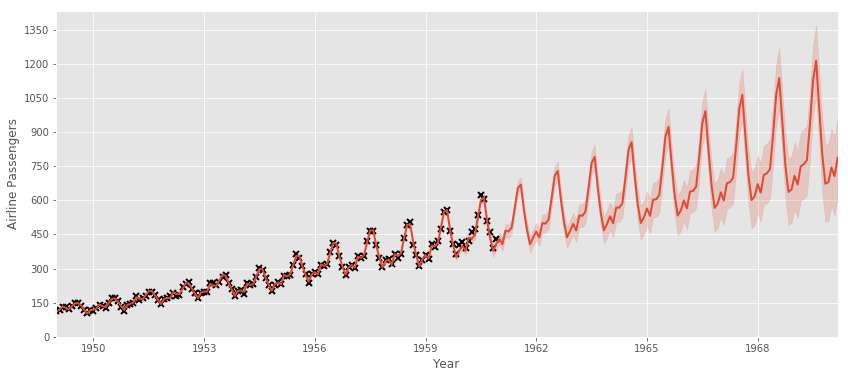

In [5]:
# Visualise
plot_model_performance(x_raw_extended, y_raw_extended, x_raw_test, mean, var)

fig = plt.gcf()

if DATA_TYPE == 'airline':
    plt.xlabel('Year')
    plt.ylabel('Airline Passengers')
    plt.ylim(bottom=0)
    plt.xlim(left=x_raw_test[0], right=x_raw_test[-1])

    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    fig.set_size_inches(14, 6)

plt.show()

In [6]:
%matplotlib inline

block0 = pd.read_csv('/gpfs/projects/UITS/IUNI/IMAGENE/Phom_output/subFeaturesAll.csv')
data = block0[['AGE','EDU','GENDER','DX']]
mask = np.isfinite(data['AGE'])
data = data[mask]
#data.DX.unique()
train, test = train_test_split(data, test_size=0.2, stratify=data.DX)
maskT = data.index.isin(train.index)
len(maskT)

K1 = pd.read_csv('/gpfs/projects/UITS/IUNI/IMAGENE/workingdir/yan30/thickPH0thinKernelPD.tsv', header=None, sep='\t').values
K1 = K1[mask,:]
K1 = K1[:,mask]
K1Tr = K1[maskT,:]
K1Tr = K1Tr[:,maskT]
K2 = pd.read_csv('/gpfs/projects/UITS/IUNI/IMAGENE/workingdir/yan30/thickPH1thinKernelPD.tsv', header=None, sep='\t').values
K2 = K2[mask,:]
K2 = K2[:,mask]
K2Tr = K2[maskT,:]
K2Tr = K2Tr[:,maskT]
n = len(K2Tr)
#K2Tr = K2Tr + 1e4 * np.eye(n)
np.linalg.cholesky(K2Tr)
#K1Tr = K1Tr + 1e4 * np.eye(n)
np.linalg.cholesky(K1Tr)

array([[ 3.00434200e+01,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.96012993e+01,  4.83130319e+01,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.81015351e+01,  1.51504982e+01,  6.56754554e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 3.51003100e+01,  5.68071246e+00,  4.29058041e+00, ...,
         1.09028155e-01,  0.00000000e+00,  0.00000000e+00],
       [ 3.67068138e+01,  3.87046801e+00,  4.31185354e+00, ...,
        -3.06059140e-03,  1.21943065e-01,  0.00000000e+00],
       [ 3.71795670e+01,  5.86067205e+00,  5.96358549e+00, ...,
        -1.28087821e-03,  3.92921440e-03,  5.58964974e-02]])

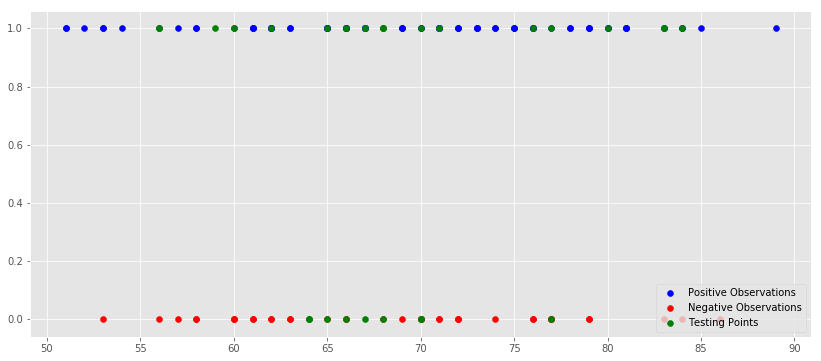

In [7]:
# Number of training points
n = len(train)
X0 = train[['AGE']].values

# Number of testing points
m = len(test)
X = test[['AGE']].values

n = len(train)
Y0 = train[['DX']].values
Y = test[['DX']].values
# Separate data into positive and negative classes
Y[Y == 'MCI'] = 1
Y[Y == 'NC'] = 0
Y0[Y0 == 'MCI'] = 1
Y0[Y0 == 'NC'] = 0

fig, ax = plt.subplots(figsize=(14, 6));
ax.scatter(X0, np.ma.masked_where(Y0 == 0, Y0), color='b', label='Positive Observations');
ax.scatter(X0, np.ma.masked_where(Y0 == 1, Y0), color='r', label='Negative Observations');
ax.scatter(X, Y, color='g', label='Testing Points');
ax.legend(loc='lower right');

In [25]:
import gpflow.kernels as kernels
import tensorflow as tf

sess = tf.InteractiveSession()

T = np.linspace(0, 4*np.pi, 100)
kern = kernels.RBF(1)

/N/soft/rhel7/deeplearning/Python-3.6.8/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [27]:
type(kern)

gpflow.kernels.RBF